<h1>Binary classifciation of images of dogs and cats - Model: VGG and ResNet</h1>

Dataset: dataset consists of
Model architecture: VGG (11, 16, and 19) and ResNet

# EDA and prepare data

In [108]:
#from google.colab import drive
#drive.mount('/content/drive')


from random import shuffle, seed
from tqdm import tqdm
import os, cv2, glob, numpy as np, pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
try:
  from torch.summary import summary
except:
  !pip install torchsummary -q
  from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms,models,datasets

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import warnings
warnings.filterwarnings('ignore')


In [11]:
root = '/content/drive/MyDrive/Courses/DeepLearning/Book_ModernComputerVision/data/cat_dog_dataset'

In [154]:
# get number of files in directories
for directory in os.listdir(root):
 print(directory)
 print(f"Dogs: {len(os.listdir(os.path.join(root,directory, 'dogs')))} | Cats: {len(os.listdir(os.path.join(root,directory,'cats')))}")


training_set
Dogs: 4006 | Cats: 4001
test_set
Dogs: 1013 | Cats: 1012


## Create dataset

In [157]:
class CustomDataset(Dataset):
  def __init__(self, root, transform=None):
    self.cats = glob(root+'/cats/*.jpg')
    self.dogs = glob(root+'/dogs/*.jpg')
    self.images = self.cats + self.dogs
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

    seed(3704)
    shuffle(self.images)
    self.targets = [1 if 'dogs' in image else 0 for image in self.images]

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx]
    target = self.targets[idx]

    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    image = torch.tensor(image/255)
    image = image.permute(2,0,1) # no need to permute this dataset, it is already in (channel, h, w) format
    image = self.normalize(image)

    return image.float().to(device), torch.tensor(target).float().to(device)

In [188]:
def DataLoader_fn(train_path, test_path, batch_size=32, num_workers=4, sample_data=False):
    '''
    Create dataloader:
      Inputs:
        train_path: path to train data
        test_path: path to test data
        batch_size: batch size
        num_workers: number of workers
        sample_data: if True, sample 100 images from train and 50 from test data
      Outputs:
        train_loader: train dataloader
        val_loader: validation dataloader
    '''

    # Create dataset
    train_data = CustomDataset(train_path)
    test_data = CustomDataset(test_path)

    if sample_data:
        train_subset = torch.utils.data.Subset(train_data, indices=np.random.choice(len(train_data), 100, replace=False))
        test_subset = torch.utils.data.Subset(test_data, indices=np.random.choice(len(test_data), 50, replace=False))

        train_loader = DataLoader(train_subset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=True)
        val_loader = DataLoader(test_subset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=True)
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
        val_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

    return train_loader, val_loader

In [189]:
data = CustomDataset(root+'/training_set/')
# to save time, get a sub-sample of train (100) and test(50)
train_loader, val_loader = DataLoader_fn(root+'/training_set/', root+'/test_set/', batch_size=32, num_workers=2, sample_data=True)

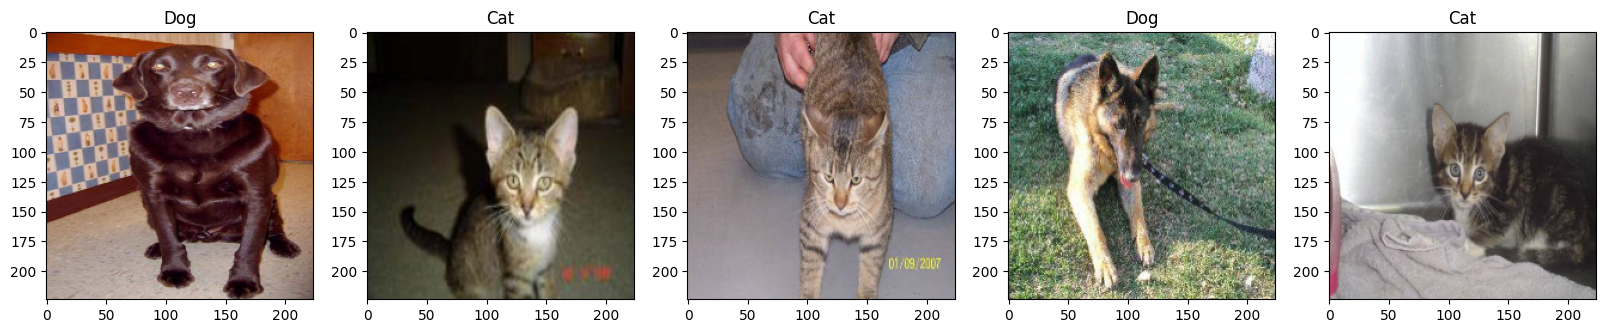

In [191]:
# Test the dataset
# get random 5 images and plot them
fig, ax = plt.subplots(1,5, figsize=(20,20))
label = 'Dog' if target == 1 else 'Cat'
for i in range(5):
  idx = np.random.randint(0,len(data))
  image, target = data[idx]
  # denormalize image
  image = image.permute(1,2,0).detach().cpu().numpy()
  image = (image*np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
  ax[i].imshow((image* 255).astype(np.uint8))
  # set title: dog if 1 cat if 0
  label = 'Dog' if target == 1 else 'Cat'
  ax[i].set_title(label)
plt.show()

In [194]:
# test dataloader
for X, y in train_loader:
  print(X.shape, y.shape)
  break

# get number of samples in train_loader
len(train_loader.dataset), len(val_loader.dataset)

torch.Size([32, 3, 224, 224]) torch.Size([32])


(100, 50)

# Define model and training functions
- VGG_model
- ResNet_model
- training_fn


In [209]:
def VGG_model(model_ver: int):
  '''
  Create VGG model, freeze features module, train avgpool and classifier
  Define loss function and optimizer: BCE and Adam

  Inputs:
    model_ver: version of VGG model (11, 16, 19)

  return:
    model: VGG model
    loss_fn: loss function
    optimizer: optimizer
  '''
  if model_ver == 11:
    model = models.vgg11(pretrained=True)
  elif model_ver == 16:
    model = models.vgg16(pretrained=True)
  elif model_ver == 19:
    model = models.vgg19(pretrained=True)
  else:
    raise ValueError('Model version not supported, model_ver = <11,16,19>')

  # freeze features module, train avgpool and classifier
  for param in model.parameters():
    param.requires_grad = False

  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1)) # force the model to return feature map 1x1 instead of 7x7
  model.classifier = nn.Sequential(nn.Flatten(),
                                   nn.Linear(in_features=512, out_features=128),
                                   nn.ReLU(),
                                   nn.Dropout(0.2),
                                   nn.Linear(in_features=128, out_features=1),
                                   nn.Sigmoid())
  # define loss function and optimizer
  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


  return model.to(device), loss_fn, optimizer

# define ResNet model
def ResNet_model(model_ver: int):
  '''
  Create ResNet model, freeze features and train avgpool and fc layers
  Define loss function and optimizer: BCE and Adam

  Inputs:
    model_ver: version of ResNet model (18, 34, 50, 101, 152)

  return:
    model: ResNet model
    loss_fn: loss function
    optimizer: optimizer
  '''

  if model_ver == 18:
    model = models.resnet18(pretrained = True)
  elif model_ver == 34:
    model = models.resnet34(pretrained  = True)
  elif model_ver == 50:
    model = models.resnet50(pretrained = True)
  elif model_ver == 101:
    model = models.resnet101(pretrained = True)
  elif model_ver == 152:
    model = models.resnet152(pretrained = True)
  else:
    raise ValueError('Model version not supported, model_ver = <18,34,50,101,152>')


  # freeze features and train avgpool and fc layers
  for param in model.parameters():
    param.requires_grad = False
  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1)) # force the model to return feature map 1x1 instead of 7x7
  model.fc = nn.Sequential(nn.Flatten(),
                           nn.Linear(in_features=512, out_features=128),
                           nn.ReLU(),
                           nn.Dropout(0.2),
                           nn.Linear(in_features=128, out_features=1),
                           nn.Sigmoid())

  # define loss function and optimizer
  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  return model.to(device), loss_fn, optimizer


In [210]:
def training_fn(X, y, model, loss_fn, optimizer):
  '''
  Train the model and return the loss

  Inputs:
    X: input data
    y: target data
    model: model to train
    loss_fn: loss function
    optimizer: optimizer
    epochs: number of epochs
  '''
  model.train()
  y_hat = model(X)
  loss_batch = loss_fn(y_hat, y.unsqueeze(1))
  loss_batch.backward()
  optimizer.step()
  optimizer.zero_grad()

  return loss_batch.item()

# Compute accuracy
@torch.no_grad()
def accuracy(X, y, model):
  '''
  Compute accuracy of the model

  Inputs:
    X: input data
    y: target data
    model: model to train
  '''
  model.eval()
  y_hat = model(X)
  y_hat = (y_hat > 0.5).float()
  acc = (y_hat == y)
  return acc.cpu().numpy().tolist()

## Create VGG16

In [205]:
# Create VGG16 and get a summary
model_vgg16, loss_fn, optimizer = VGG_model(16)
summary(model_vgg16, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## Training VGG16

In [206]:
train_losses, train_accs, val_accs = [], [], []

for eporch in range(2):
  print(f'Epoch: {eporch+1}')
  train_batch_losses, train_batch_accs, val_batch_accs = [], [], []

  for i, batch in enumerate(tqdm(train_loader)):
    X, y = batch
    loss = training_fn(X, y, model_vgg16, loss_fn, optimizer)
    train_batch_losses.append(loss)
  train_epoch_loss = np.array(train_batch_losses).mean()



  for i, batch in enumerate(tqdm(val_loader)):
    X, y = batch
    acc = accuracy(X, y, model_vgg16)
    train_batch_accs.extend(acc)
  train_epoch_acc = np.mean(train_batch_accs)

  for i, batch in enumerate(tqdm(val_loader)):
    X, y = batch
    acc = accuracy(X, y, model_vgg16)
    val_batch_accs.extend(acc)
  val_epoch_acc = np.mean(val_batch_accs)

  train_losses.append(train_epoch_loss)
  train_accs.append(train_epoch_acc)
  val_accs.append(val_acc)

Epoch: 1


100%|██████████| 1/1 [00:33<00:00, 33.34s/it]


Epoch: 2


100%|██████████| 1/1 [00:30<00:00, 30.02s/it]


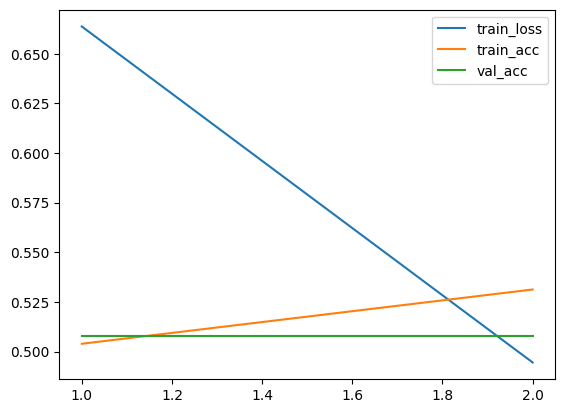

In [208]:
# print the results
epochs = np.arange(1, len(train_losses)+1)
plt.plot(epochs, train_losses, label='train_loss')
plt.plot(epochs, train_accs, label='train_acc')
plt.plot(epochs, val_accs, label='val_acc')
plt.legend()
plt.show();

# Create ResNet18

In [211]:
# create ResNet18 and get a summary
model_resnet18, loss_fn, optimizer = ResNet_model(18)
summary(model_resnet18, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 90.1MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Train ResNet18

In [214]:
train_losses, train_accs, val_accs = [], [], []

for eporch in range(5):
  print(f'Epoch: {eporch+1}')
  train_batch_losses, train_batch_accs, val_batch_accs = [], [], []

  for i, batch in enumerate(tqdm(train_loader)):
    X, y = batch
    loss = training_fn(X, y, model_resnet18, loss_fn, optimizer)
    train_batch_losses.append(loss)
  train_epoch_loss = np.array(train_batch_losses).mean()



  for i, batch in enumerate(tqdm(val_loader)):
    X, y = batch
    acc = accuracy(X, y, model_resnet18)
    train_batch_accs.extend(acc)
  train_epoch_acc = np.mean(train_batch_accs)

  for i, batch in enumerate(tqdm(val_loader)):
    X, y = batch
    acc = accuracy(X, y, model_resnet18)
    val_batch_accs.extend(acc)
  val_epoch_acc = np.mean(val_batch_accs)

  train_losses.append(train_epoch_loss)
  train_accs.append(train_epoch_acc)
  val_accs.append(val_acc)

Epoch: 1


100%|██████████| 1/1 [00:03<00:00,  3.92s/it]


Epoch: 2


100%|██████████| 1/1 [00:05<00:00,  5.19s/it]


Epoch: 3


100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


Epoch: 4


100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


Epoch: 5


100%|██████████| 1/1 [00:05<00:00,  5.92s/it]


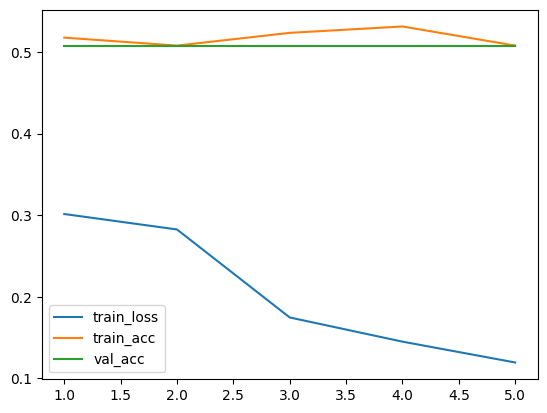

In [215]:
# print the results
epochs = np.arange(1, len(train_losses)+1)
plt.plot(epochs, train_losses, label='train_loss')
plt.plot(epochs, train_accs, label='train_acc')
plt.plot(epochs, val_accs, label='val_acc')
plt.legend()
plt.show();